# Simulating the formation of myosin clusters
In this notebook, I constructed a simple toy model to simulate the growth of myosin clusters via accretion. 

There are a series of random grids where myosin could bind (indices `0` to `numGrid`)

Each grid is initialized with an initial number of myosin & F-actin density.

In each iteration, a single myosin lands on a random grid based on a probability distribution, which is proportional to a) the F-actin density, and/or b) existing number of myosin on that grid. 

Repeat the process until all myosin have landed to a grid.

In [1]:
# Import packages
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from random import choices
import seaborn as sns
import random
from scipy.spatial import Delaunay
from numpy.random import default_rng
import pandas as pd
#import networkx as nx


## 1D myosin binding simulation

### Setting up the simulation

In [62]:
# Define function that generates the underlying actin distribution
def GenActinThick(method, numGrid, *keys):
    rng = default_rng(seed=100)    # enforce reproducibility
    if method == 'lognormal':
        ## Passed argument should be mu and sigma
        (mu, sigma) = keys
        ActinThick = rng.lognormal(mu, sigma, (numGrid))
    elif method == 'normal':
        ## Passed argument should be loc and scale
        (loc, scale) = keys
        ActinThick = rng.normal(loc, scale, (numGrid))
    elif method == 'uniform':
        ## Passed argument should be low and high
        (low, high) = keys
        ActinThick = rng.uniform(low, high, (numGrid))
    elif method == 'poisson':
        ## Passed argument should be lambda
        lam = keys
        ActinThick = rng.poisson(lam, (numGrid))
    else:
        raise ValueError('Method not supported!')
    return ActinThick#.astype(int)

# Define function that generates the initial myosin cluster size
def GenMyoNum(method, numMyosin, *keys):
    rng = default_rng(seed=42)    # enforce reproducibility
    if method == 'lognormal':
        ## Passed argument should be mu and sigma
        (mu, sigma) = keys
        myosinNum = rng.lognormal(mu, sigma, (numMyosin))
    elif method == 'normal':
        ## Passed argument should be loc and scale
        (loc, scale) = keys
        myosinNum = rng.normal(loc, scale, (numMyosin))
    elif method == 'uniform':
        ## Passed argument should be low and high
        (low, high) = keys
        myosinNum = rng.uniform(low, high, (numMyosin))
    elif method == 'poisson':
        ## Passed argument should be lambda
        lam = keys
        myosinNum = rng.poisson(lam, (numMyosin))
    else:
        raise ValueError('Method not supported!')
    return myosinNum#.astype(int)

# Define function that runs simulation based on weights that are defined
def runSimulation(numGrid, numMyosin, MyosinInit, ActinInit, actinBiasVal, myosinBiasVal, ifsave, dwnsample):
    ### numGrid: number of grid points
    ### numMyosin: number of new myosin filaments to bind
    ### MyosinNum: initial myosin cluster size
    ### ActinThick: initial F-actin density
    ### actinBiasVal, myosinBiasVal: degree of affinity for new myosin to bind to actin or myosin

    MyosinNum = MyosinInit.copy()
    ActinThick = ActinInit.copy()
    
    if ifsave:
        MyosinNumHist = np.zeros((numGrid, int(numMyosin/dwnsample)))

    random.seed(42)    # Reproducibility
    # Define probability weights and draw random grid number that myosin lands
    for ii in range(numMyosin):
        index = np.arange(0, numGrid)
        actinBias = ActinThick * actinBiasVal
        myosinBias = MyosinNum * myosinBiasVal
        weights = np.ones((numGrid)) + actinBias + myosinBias
        #weights = weights * np.exp(-MyosinNum/ActinThick/myoCap)
        weights = weights/np.sum(weights) #* np.exp(-np.maximum(0, np.array(MyosinNum)-myoCap))     ## Binding probability exponentially decays if exceeds binding capacity
        #weights[np.array(MyosinNum)>=myoCap] = 0   ###!!!!!!! Anything site that exceed capacity can't bind
        if len(np.nonzero(weights)[0]) == 0:    ### Terminate if no more available sites
            break
        else:
            landing = choices(index, weights)
            MyosinNum[landing] = MyosinNum[landing] + 1
        
        if ifsave:
            if ii%dwnsample == 0:
                MyosinNumHist[:, ii//dwnsample] = MyosinNum.T

    if ifsave:
        return MyosinNum, MyosinNumHist
    else:
        return MyosinNum

In [36]:
    #### Archaic codes
        #numMerger = numGrid*activity
        #if numMerger>0 and numMerger<1:
        #    numMerger = np.random.random_sample()<numMerger
        
        #if numMerger > 0.0:
        #    numMerger = round(numMerger)
        #    merger_id = np.random.randint(0, numGrid-1, (numMerger))
        #    for edges in merger_id:
        #        MyosinNum[edges]=MyosinNum[edges]+MyosinNum[edges+1]
        #        MyosinNum[edges+1]=-1
        #        ActinThick[edges]=ActinThick[edges]+ActinThick[edges+1]
        #        ActinThick[edges+1]=-1
        #    MyosinNum = MyosinNum[MyosinNum!=-1]
        #    #print(MyosinNum.shape)
        #    ActinThick = ActinThick[ActinThick!=-1]
        #    #print(ActinThick.shape)
        #    numGrid -= numMerger

        #diff = np.abs(MyosinNum[1:] - MyosinNum[0:-1])
        #merge_cand = np.where(diff>merge_thresh)[0]
        #for jj in merge_cand:
        #    if np.random.rand()<Pmerge:
        #        (mergeId, tomerge) = (jj, jj+1)
        #        if MyosinNum[jj]<MyosinNum[jj+1]:
        #            (mergeId, tomerge) = (jj+1, jj)
        #        MyosinNum[mergeId]=MyosinNum[mergeId]+MyosinNum[tomerge]
        #        MyosinNum[tomerge]=0
        #        ActinThick[jj]=ActinThick[jj]+ActinThick[tomerge]
        #        ActinThick[tomerge]=1

        #if dis_rate > 0.0:
        #    numDisassemble = math.floor(dis_rate)
        #    if (dis_rate-numDisassemble) > np.random.random_sample():
        #        numDisassemble += 1
        #    dis_prob = np.array(MyosinNum) * np.exp(-np.array(MyosinNum))
        #    count = 0
        #    while count < numDisassemble:
        #        dis_id = choices(index, dis_prob)
        #        MyosinNum[dis_id] = 0
        #        count += 1

### Visualize initial conditions to be used

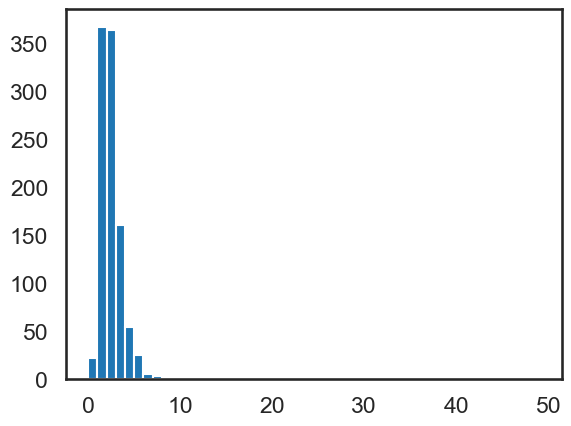

In [37]:
lognormNum = GenMyoNum('lognormal', 1000, 1.8, 0.6)
lognormNum1 = GenMyoNum('lognormal', 1000, 0.8, 0.4)
gaussNum = GenMyoNum('normal', 1000, 3, 0.6)
plt.hist(lognormNum1, bins = np.arange(50))
plt.show()

In [3]:
# Load experimental data
allPointDataYB = pd.read_csv('allPointData_YB.csv')
allPointDataYB.head()

,labels,x,y,intensity
0,cell1,373.529876,878.947456,3539.935224
1,cell1,381.585359,882.036750,4665.215992
2,cell1,381.609805,887.437442,5115.323621
3,cell1,382.596995,903.567588,1868.539465
4,cell1,383.381948,897.635095,2517.216225


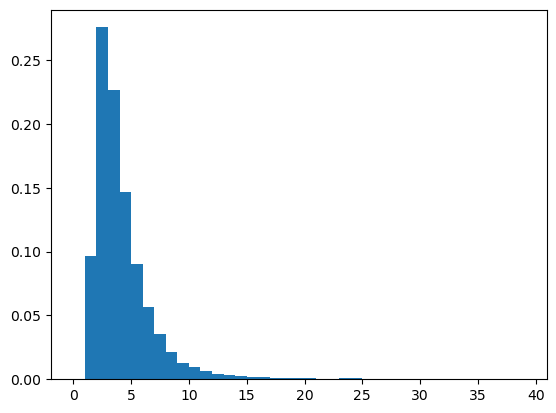

In [4]:
# "Size" distribution of Y+B+ experiments
for ii in allPointDataYB['labels'].unique():
    allInt_sub = allPointDataYB[allPointDataYB['labels']==ii]
    normInt = allInt_sub['intensity']/np.min(allInt_sub['intensity'])
    if ii == 'cell1':
        allIntYB = normInt.copy()
    else:
        allIntYB = pd.concat([allIntYB, normInt.copy()], ignore_index=True)
#print(allPointDataYB['labels'].unique())
#allPointDataYB['intensity']/np.min(allPointDataYB['intensity'])
plt.hist(allIntYB, bins = np.arange(40), density = True)
plt.show()

In [40]:
(s, loc, scale) = st.lognorm.fit(allIntYB, floc = 0)
print('Using experimental conditions, the initial lognormal distribution for the simulation should have mu:', np.log(scale), ', and  should be:', s)

Using experimental conditions, the initial lognormal distribution for the simulation should have mu: 1.3097472527725154 , and  should be: 0.5204161226594383


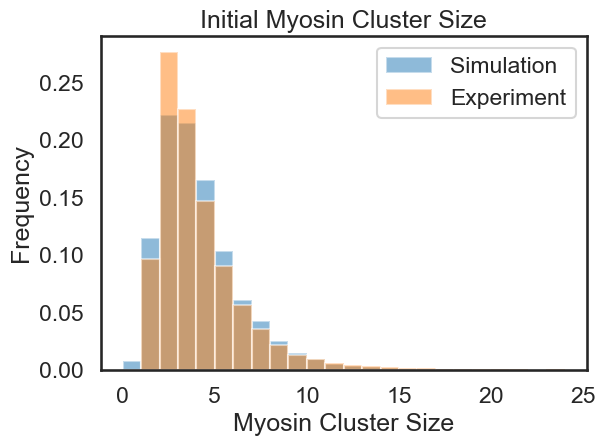

In [5]:
lognormNum1 = GenMyoNum('lognormal', 10000, 1.31, 0.52)
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(lognormNum1, bins = np.arange(25), density = True, alpha = 0.5, label = 'Simulation')
plt.hist(allIntYB, bins = np.arange(25), density = True, alpha = 0.5, label = 'Experiment')
plt.title('Initial Myosin Cluster Size')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('Initial cluster size.png')

In [6]:
print(np.sum(lognormNum1))

42174.517690423454


### Test visulization

In [43]:
# Kymograph
numMyosin = 3000
numGrid = 1000
actinBiasVal = 0
myosinBiasVal = 5
ifsave = 1
dwnsample = 10
ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 

res, kymo = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal, ifsave, dwnsample)

plt.figure()
plt.imshow(kymo, cmap = 'viridis', vmin=0, vmax=30)
plt.xticks([])
plt.yticks([])
plt.xlabel('Iterations')
plt.ylabel('Grid position')
#plt.show()
plt.tight_layout()
#plt.savefig('myosinBinding_kymograph_acBias_half_myoBias_half')

KeyboardInterrupt: 

In [ ]:
kymo.shape

(10000, 1000)

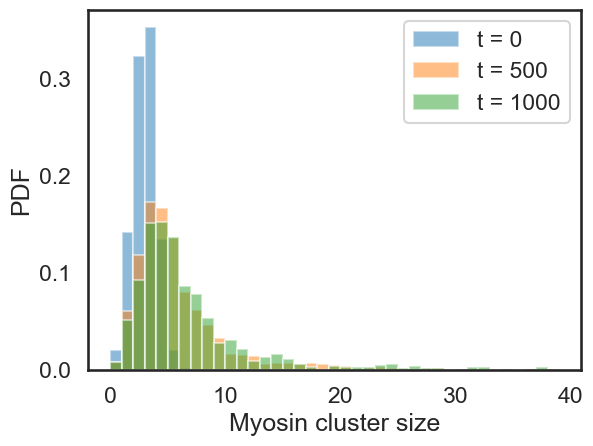

In [ ]:
# Evolution of histogram
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
#myoCap = 30
actinBiasVal = .5
myosinBiasVal = .5
res, myoHist = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, 1, 10)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(myoHist[:,0], bins = np.arange(40), density = True, alpha = 0.5, label = 't = 0')
plt.hist(myoHist[:,499], bins = np.arange(40), density = True, alpha = 0.5, label = 't = 500')
plt.hist(myoHist[:,999], bins = np.arange(40), density = True, alpha = 0.5, label = 't = 1000')
plt.legend()
plt.xlabel('Myosin cluster size')
plt.ylabel('PDF')
#plt.show()
plt.tight_layout()
plt.savefig('myosinBinding_histoEvolve_acBias_half_myoBias_half')

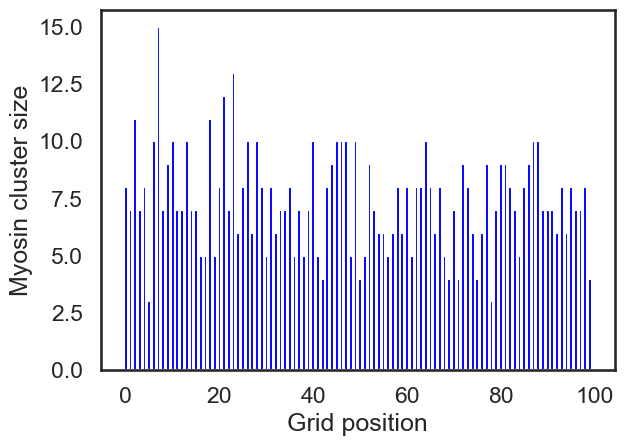

In [ ]:
# Bar plot
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
#myoCap = 30
actinBiasVal = 0
myosinBiasVal = 0
res, myoHist = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, 1, 10)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.bar(np.arange(100), myoHist[:100,500], color = 'blue')
plt.xlabel('Grid position')
plt.ylabel('Myosin cluster size')
#plt.show()
plt.tight_layout()
plt.savefig('myosinBinding_bar_acBias_0_myoBias_0')

## Accretion with no bias towards myosin or actin

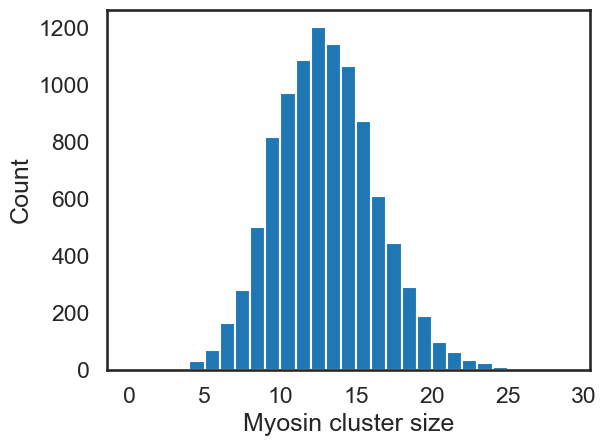

In [ ]:
# Simulation ROCK-dependent cluster growth: no biases, random binding
numMyosin = 10000
numGrid = 1000
actinBiasVal = 0
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.
numSim = 10

allRes = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes[ii, :] = res

sns.set_style("white")
sns.set_context("talk")
plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(30))
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.tight_layout()
#plt.savefig("myosinBinding_histogram_acBias_0_myoBias_0.png", dpi = 300)

## Accretion with myosin bias (Blebbistatin $\pm$ Y-27)

### Scan $\alpha$ to match with experimental conditions

In [5]:
# Load experimental data
allPointDataYoutB = pd.read_csv('allPointData_YoutB.csv')
allPointDataYoutB.head()

,labels,x,y,intensity
0,cell1,445.898295,848.799659,3120.365625
1,cell1,452.905939,852.814262,2517.818702
2,cell1,454.251963,848.456719,3118.491720
3,cell1,456.372308,813.807775,6305.371871
4,cell1,458.456133,824.918940,3814.982536


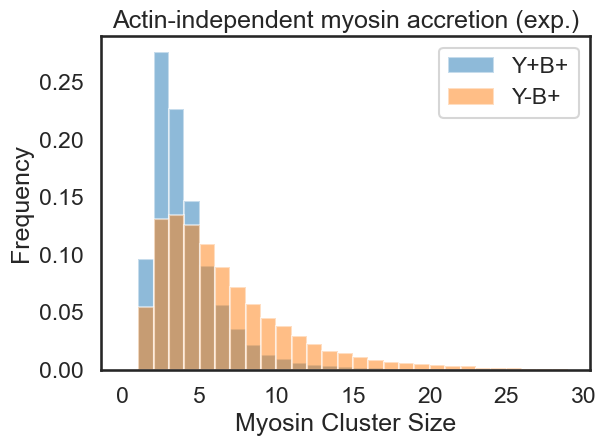

In [6]:
# "Size" distribution of Y+B+ experiments
for ii in allPointDataYoutB['labels'].unique():
    allInt_sub = allPointDataYoutB[allPointDataYoutB['labels']==ii]
    normInt = allInt_sub['intensity']/np.min(allInt_sub['intensity'])
    if ii == 'cell1':
        allIntYoutB = normInt.copy()
    else:
        allIntYoutB = pd.concat([allIntYoutB, normInt.copy()], ignore_index=True)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(allIntYB, bins = np.arange(30), alpha=0.5, density=True, label='Y+B+')
plt.hist(allIntYoutB, bins = np.arange(30), alpha=0.5, density = True, label='Y-B+')
plt.title('Actin-independent myosin accretion (exp.)')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('YoutB.png')

In [7]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a, label, line, color):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post', alpha = 0.5, linestyle = line, color = color, label = label)
    plt.grid(True)

In [10]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a, label, line, color):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post', alpha = 0.5, linestyle = line, color = color, label = label)
    plt.grid(True)

numGrid = 10000
ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
numMyosin = [int(np.sum(MyosinInit)*2/3)]
actinBiasVal = 0
myosinBiasVal = [0, 30]
ifsave = 0
dwnsample = 1

#acBias = np.zeros((len(myosinBiasVal)))
#myoBias = np.zeros((len(myosinBiasVal)))
#mode_array = np.zeros((len(myosinBiasVal)))
#sigma_array = np.zeros((len(myosinBiasVal)))
# Initialize and run simulation

for ii in range(len(numMyosin)):
    for jj in range(len(myosinBiasVal)):
        
        res = runSimulation(numGrid, numMyosin[ii], MyosinInit, ActinThick, actinBiasVal, myosinBiasVal[jj], ifsave, dwnsample)

        # Save mu, sigma
        allData = np.reshape(res, (numGrid))
        (s, loc, scale) = st.lognorm.fit(allData[allData>0], floc = 0)
        #acBias[jj] = actinBiasVal
        #myoBias[jj] = myosinBiasVal[jj]
        #mode_array[jj] = np.exp(np.log(scale)-s**2)
        #sigma_array[jj] = s

        co = sns.color_palette()
        # Save histogram
        plt.figure()
        sns.set_style("white")
        sns.set_context("talk")
        xfit = np.arange(0, 30, 0.2)
        plt.hist(MyosinInit, bins = np.arange(30), alpha=0.5, color = co[0], density = True, label = 'Initial condition')
        plt.hist(res, bins = np.arange(30), alpha=0.5, color = co[1], density = True, label = 'Final cluster size')
        #plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.savefig('myosinBinding_histogram_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_'+str(myosinBiasVal[jj])+'_acBias_0.png', dpi = 300, transparent = True)
        plt.close()

        # Save CDF
        plt.figure()
        sns.set_style("white")
        sns.set_context("poster")
        plot_ecdf(allIntYoutB, 'Experiment', '--', co[1])
        plot_ecdf(res, 'Simulation', '-', co[1])
        plt.title('Cumulative distribution')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.xlim([0, 30])
        plt.tight_layout()
        plt.savefig('myosinBinding_ecdf_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_'+str(myosinBiasVal[jj])+'_acBias_0.png', dpi = 300, transparent = True)
        plt.close()

#df = pd.DataFrame({'alpha': myoBias, 'beta': acBias, 'mode': mode_array, 'sigma': sigma_array})
#df.to_csv('params.csv')


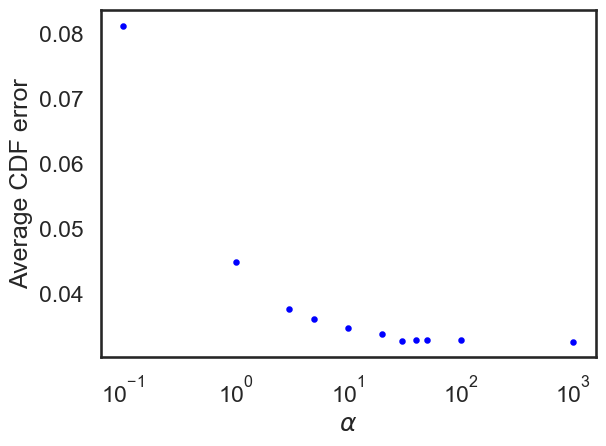

In [9]:
def cdf_dist(data1, data2):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    data_all = np.concatenate([data1, data2])
    cdf_sim = np.searchsorted(data1, data_all, side='right') / data1.shape[0]
    cdf_exp = np.searchsorted(data2, data_all, side='right') / data2.shape[0]
    cddiffs = cdf_exp - cdf_sim
    dist = np.sum(np.abs(cddiffs)) / data_all.shape[0]

    return dist

numGrid = 10000
ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
numMyosin = int(np.sum(MyosinInit)*2/3)
actinBiasVal = 0
myosinBiasVal = [0.1, 1, 3, 5, 10, 20, 30, 40, 50, 100, 1000]
ifsave = 0
dwnsample = 1

dist_arr = np.zeros((len(myosinBiasVal)))

for ii in range(len(myosinBiasVal)):
    res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal[ii], ifsave, dwnsample)
    #test = st.ks_2samp(res, allIntYoutB[allIntYoutB<=np.max(res)])

    dist_arr[ii] = cdf_dist(res, allIntYoutB)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.scatter(myosinBiasVal, dist_arr, 10, 'blue')
plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("Average CDF error")
plt.tight_layout()
plt.savefig("Ywashout_alpha scan.png", dpi = 300, transparent = True)

In [90]:
print(len(allIntYoutB))

38026


In [ ]:
## Example histograms of alpha = 0
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a, label):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post', label = label)
    plt.grid(True)

# Simulation parameters
numMyosin = [10000, 30000, 50000]
numGrid = 10000
actinBiasVal = 0
myosinBiasVal = 0
ifsave = 0
dwnsample = 1

sns.set_style("white")
sns.set_context("talk")
plt.figure(1)

for ii in range(len(numMyosin)):
    # Initialize and run simulation
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
    res = runSimulation(numGrid, numMyosin[ii], MyosinInit, ActinThick, actinBiasVal, myosinBiasVal, ifsave, dwnsample)
    
    # Save histogram
    sns.set_style("white")
    sns.set_context("talk")
    plt.figure()
    xfit = np.arange(0, 30, 0.2)
    plt.hist(MyosinInit, bins = np.arange(30), alpha=0.5, density = True, label = 'Initial condition')
    plt.hist(res, bins = np.arange(30), alpha=0.5, density = True, label = 'numMyosin='+str(numMyosin[ii]))
    plt.xlabel("Myosin cluster size")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.savefig('myosinBinding_histogram_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_0_acBias_0.png', dpi = 300, transparent = True)
    plt.close()

    # Save CDF
    sns.set_style("white")
    sns.set_context("poster")
    plt.figure()
    plot_ecdf(allIntYoutB, 'Experiment')
    plot_ecdf(res, 'numMyosin='+str(numMyosin[ii]))
    plt.title('Cumulative distribution')
    plt.xlabel("Myosin cluster size")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.savefig('myosinBinding_ecdf_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_0_acBias_0.png', dpi = 300, transparent = True)
    plt.close()

#plt.savefig("myosinBinding_histogramComp_acBias_0_mu_1_sigma_1_myoBiasComp.png", dpi = 300)

<Figure size 640x480 with 0 Axes>

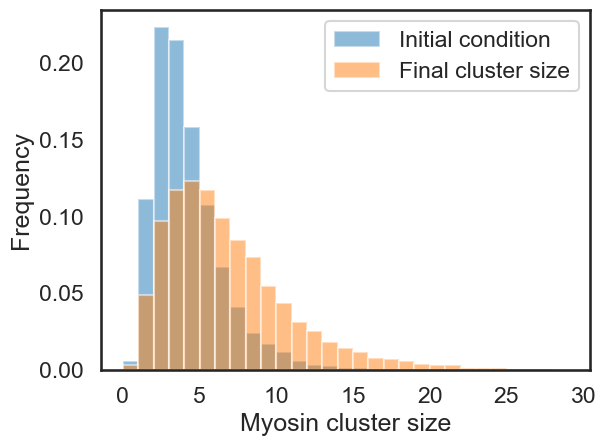

In [45]:
numMyosin = 26000
numGrid = 10000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 0
myosinBiasVal = [5]
ifsave=0
dwnsample=1


sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(MyosinInit, bins = np.arange(30), alpha=0.5, density = True, label = 'Initial condition')

for ii in range(len(myosinBiasVal)):
    # Run simulations
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
    res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal[ii], ifsave, dwnsample)

    plt.hist(res, bins = np.arange(30), alpha = 0.5, density = True, label = 'Final cluster size')

plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("myosinBinding_histogramComp_numMyosin_26000_acBias_0_myosinBias_5.png", dpi = 300, transparent = True)

In [55]:
numMyosin = 26000
numGrid = 10000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 0
myosinBiasVal = [0, 5]
ifsave=0
dwnsample=1

# Run simulations
ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
#res0 = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal[0], ifsave, dwnsample)
res1 = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal[1], ifsave, dwnsample)

sns.set_style("white")
sns.set_context("poster")
plt.figure()
plot_ecdf(allIntYoutB, 'Experiment')
#plot_ecdf(res0, 'Simulation')
plot_ecdf(res1, 'Simulation')
plt.title('Cumulative distribution')
plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()
plt.xlim([0, 30])
plt.tight_layout()
plt.savefig('myosinBinding_ecdf_numGrid10000_numMyosin_26000_acBias_0_myoBias_5.png', dpi = 300, transparent = True)
plt.close()

## Accretion with both myosin & F-actin bias (Bleb vs Ctrl or Y+B+ vs Y-B-)

### Initial conditions

In [8]:
allPointDataBB = pd.read_csv('allPointDataBB.csv')
allPointDataBB.head()

,labels,x,y,intensity
0,cell1,183.271200,623.056458,2004.770497
1,cell1,183.866520,675.729873,2927.096330
2,cell1,184.361366,688.352109,2228.139469
3,cell1,190.513000,625.742408,2759.057944
4,cell1,193.046247,720.858748,3596.843203


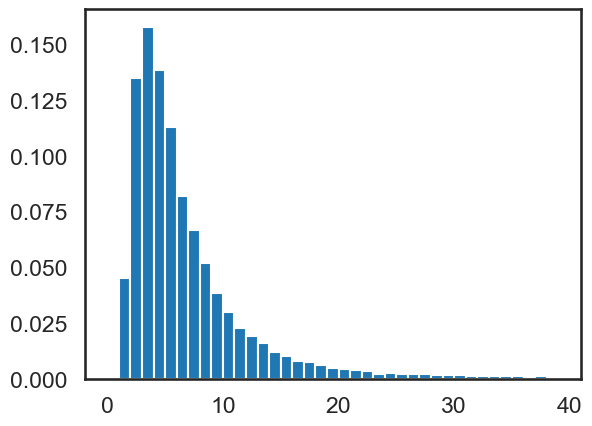

In [10]:
# "Size" distribution of blebbistatin experiments
for ii in allPointDataBB['labels'].unique():
    allInt_sub = allPointDataBB[allPointDataBB['labels']==ii]
    normInt = allInt_sub['intensity']/np.min(allInt_sub['intensity'])
    if ii == 'cell1':
        allIntBB = normInt.copy()
    else:
        allIntBB = pd.concat([allIntBB, normInt.copy()], ignore_index=True)
#print(allPointDataYB['labels'].unique())
#allPointDataYB['intensity']/np.min(allPointDataYB['intensity'])
plt.hist(allIntBB, bins = np.arange(40), density = True)
plt.show()

In [ ]:
(s, loc, scale) = st.lognorm.fit(allIntBB, floc = 0)
print('Using experimental conditions, the initial lognormal distribution for the simulation should have mu:', np.log(scale), ', and sigma should be:', s)

Using experimental conditions, the initial lognormal distribution for the simulation should have mu: 1.7307717427442268 , and sigma should be: 0.7003005502092207


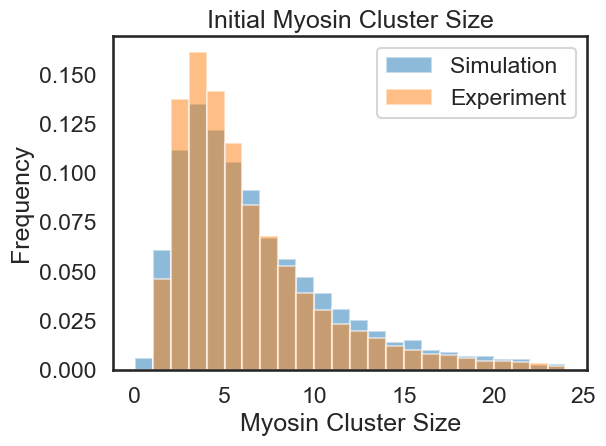

In [50]:
lognormNum2 = GenMyoNum('lognormal', 10000, 1.73, 0.7)
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(lognormNum2, bins = np.arange(25), density = True, alpha = 0.5, label = 'Simulation')
plt.hist(allIntBB, bins = np.arange(25), density = True, alpha = 0.5, label = 'Experiment')
plt.title('Initial Myosin Cluster Size')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('Initial cluster size_bleb.png')

In [27]:
print(np.sum(GenMyoNum('lognormal', 10000, 1.73, 0.7)))

71793.35154214597


#### Draw random number from experimental distribution & check empirical pdf

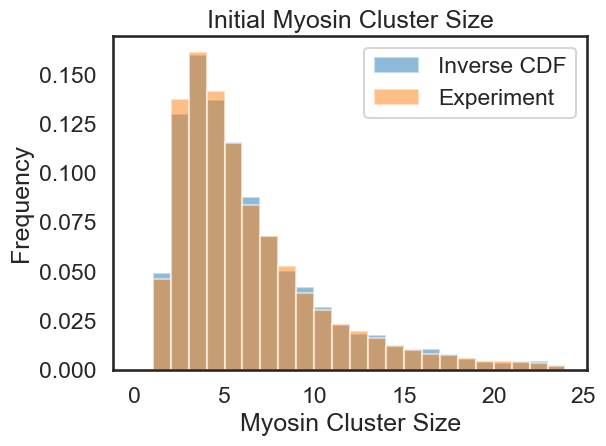

In [77]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

x, BB_cdf = ecdf(allIntBB)
randNum = np.zeros((10000))
for ii in range(10000):
    u = np.random.uniform()
    idx = np.argmin(BB_cdf<=u)
    randNum[ii] = x[idx]

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(randNum, bins = np.arange(25), density = True, alpha = 0.5, label = 'Inverse CDF')
plt.hist(allIntBB, bins = np.arange(25), density = True, alpha = 0.5, label = 'Experiment')
plt.title('Initial Myosin Cluster Size')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()


In [11]:
allPointDataYoutBout = pd.read_csv('allPointData_YoutBout.csv')
allPointDataYoutBout.head()

,labels,x,y,intensity
0,cell1,413.417293,797.549845,2288.558499
1,cell1,412.913753,807.098468,3141.368860
2,cell1,414.489258,814.828410,6696.037809
3,cell1,417.493605,678.799118,1416.206733
4,cell1,418.776214,722.533579,915.986148


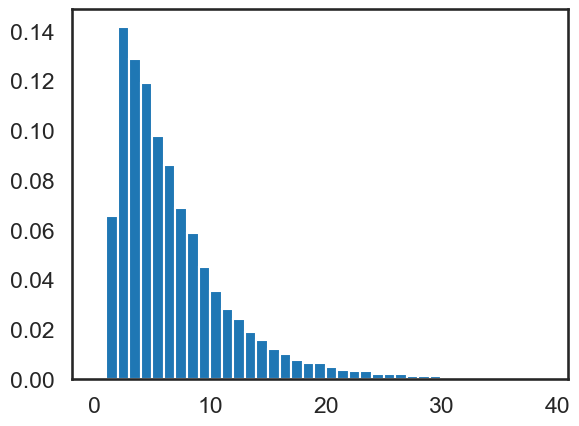

In [12]:
for ii in allPointDataYoutBout['labels'].unique():
    allInt_sub = allPointDataYoutBout[allPointDataYoutBout['labels']==ii]
    normInt = allInt_sub['intensity']/np.min(allInt_sub['intensity'])
    if ii == 'cell1':
        allIntYoutBout = normInt.copy()
    else:
        allIntYoutBout = pd.concat([allIntYoutBout, normInt.copy()], ignore_index=True)
#print(allPointDataYB['labels'].unique())
#allPointDataYB['intensity']/np.min(allPointDataYB['intensity'])
plt.hist(allIntYoutBout, bins = np.arange(40), density = True)
plt.show()

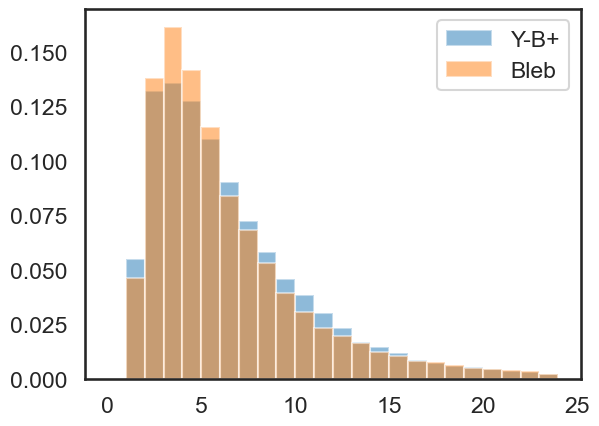

In [40]:
### Compare 
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(allIntYoutB, bins = np.arange(25), density = True, alpha = 0.5, label = 'Y-B+')
plt.hist(allIntBB, bins = np.arange(25), density = True, alpha = 0.5, label = 'Bleb')
plt.legend()
plt.show()

### Initial conditions for F-actin density

In [13]:
allBundleInt = pd.read_csv('allBundleInt_WT.csv')
allBundleInt.head()

,labels,int_arr
0,cell1,2332
1,cell1,2332
2,cell1,2309
3,cell1,2309
4,cell1,2312


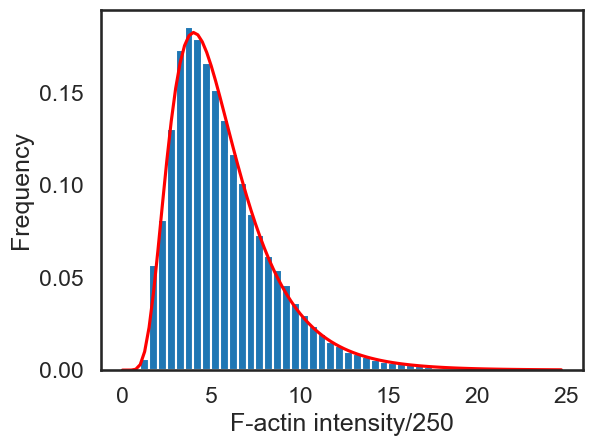

In [14]:
(s, loc, scale) = st.lognorm.fit(allBundleInt['int_arr']/250, floc = 0)
plt.figure()
plt.hist(allBundleInt['int_arr']/250, bins = np.arange(0, 25, 0.5), density = True)
xfit = np.arange(0, 25, 0.25)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
plt.xlabel('F-actin intensity/250')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('Initial_actin')

In [ ]:
print('After scaling, the F-actin density is fitted to a lognormal with mu = ', np.log(scale), ' and sigma = ', s)

After scaling, the F-actin density is fitted to a lognormal with mu =  1.6233542902018876  and sigma =  0.48368810447717353


### Scan $\beta$ to match experimental conditions

In [15]:
# Load experimental data
allPointDataWT = pd.read_csv('allPointDataWT.csv')
allPointDataWT.head()

,labels,x,y,intensity
0,cell1,133.103870,778.926337,3370.810842
1,cell1,133.951202,753.215117,9084.421618
2,cell1,138.152704,760.248273,1635.657255
3,cell1,141.762984,778.100500,15486.452430
4,cell1,145.103032,790.611341,1692.924150


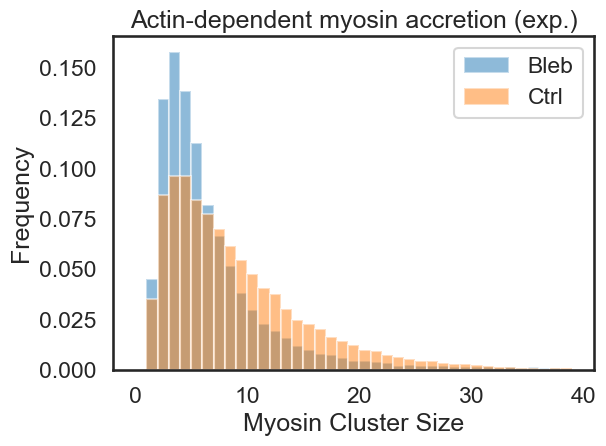

In [16]:
# "Size" distribution of Y+B+ experiments
for ii in allPointDataWT['labels'].unique():
    allInt_sub = allPointDataWT[allPointDataWT['labels']==ii]
    normInt = allInt_sub['intensity']/np.min(allInt_sub['intensity'])
    if ii == 'cell1':
        allIntWT = normInt.copy()
    else:
        allIntWT = pd.concat([allIntWT, normInt.copy()], ignore_index=True)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(allIntBB, bins = np.arange(40), alpha=0.5, density=True, label='Bleb')
plt.hist(allIntWT, bins = np.arange(40), alpha=0.5, density = True, label='Ctrl')
plt.title('Actin-dependent myosin accretion (exp.)')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('BB_ctrl.png')

In [17]:
#### Define functions that calculate CDF and plot CDF
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a, label, line, color):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post', alpha = 0.5, linestyle = line, color = color, label = label)
    plt.grid(True)
    
def cdf_dist(data1, data2):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    data_all = np.concatenate([data1, data2])
    cdf_sim = np.searchsorted(data1, data_all, side='right') / data1.shape[0]
    cdf_exp = np.searchsorted(data2, data_all, side='right') / data2.shape[0]
    cddiffs = cdf_exp - cdf_sim
    dist = np.sum(np.abs(cddiffs)) / data_all.shape[0]

    return dist

#### From Y+B+ to ctrl

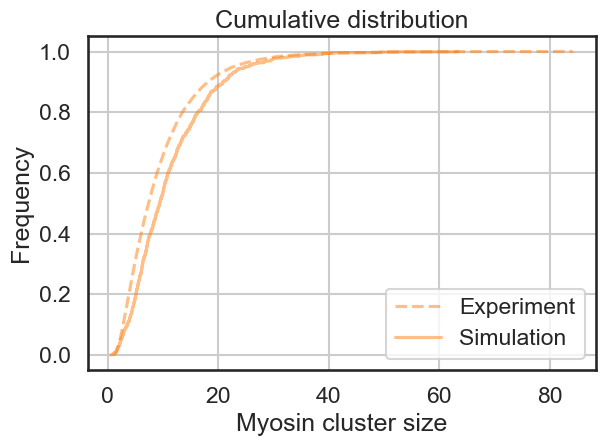

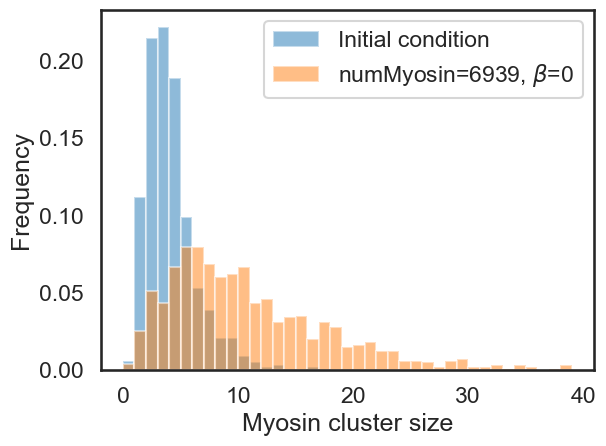

In [19]:
# Scan parameters to recapitulate experimental results
numGrid = 1000
ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
#MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
numMyosin = [int(np.sum(MyosinInit)*5/3)]
actinBiasVal = [0]
myosinBiasVal = 100
ifsave = 0
dwnsample = 1

#acBias = np.zeros((len(myosinBiasVal)))
#myoBias = np.zeros((len(myosinBiasVal)))
#mode_array = np.zeros((len(myosinBiasVal)))
#sigma_array = np.zeros((len(myosinBiasVal)))
# Initialize and run simulation
co = sns.color_palette()
for ii in range(len(numMyosin)):
    for jj in range(len(actinBiasVal)):
        
        res = runSimulation(numGrid, numMyosin[ii], MyosinInit, ActinThick, actinBiasVal[jj], myosinBiasVal, ifsave, dwnsample)

        # Save CDF
        sns.set_style("white")
        sns.set_context("talk")
        plt.figure()
        plot_ecdf(allIntWT, 'Experiment', '--', co[1])
        plot_ecdf(res, 'Simulation', '-', co[1])
        plt.title('Cumulative distribution')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        #plt.savefig('myosinBinding_ecdf_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_0_acBias_'+str(actinBiasVal[jj])+'.png', dpi = 300)
        #plt.close()

        # Save mu, sigma
        allData = np.reshape(res, (numGrid))
        (s, loc, scale) = st.lognorm.fit(allData[allData>0], floc = 0)
        #acBias[jj] = actinBiasVal
        #myoBias[jj] = myosinBiasVal[jj]
        #mode_array[jj] = np.exp(np.log(scale)-s**2)
        #sigma_array[jj] = s

        # Save histogram
        sns.set_style("white")
        sns.set_context("talk")
        plt.figure()
        xfit = np.arange(0, 40, 0.5)
        plt.hist(MyosinInit, bins = np.arange(40), alpha=0.5, density = True, label = 'Initial condition')
        plt.hist(res, bins = np.arange(40), alpha=0.5, density = True, label = 'numMyosin='+str(numMyosin[ii])+r', $\beta$='+str(actinBiasVal[jj]))
        #plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        #plt.savefig('myosinBinding_histogram_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_0_acBias_'+str(actinBiasVal[jj])+'.png', dpi = 300)
        #plt.close()

#df = pd.DataFrame({'alpha': myoBias, 'beta': acBias, 'mode': mode_array, 'sigma': sigma_array})
#df.to_csv('params.csv')

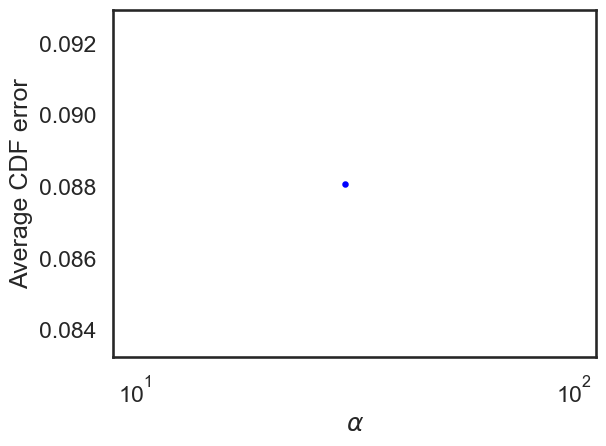

In [71]:
numGrid = 1000
ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
numMyosin = int(np.sum(MyosinInit)*5/3)
actinBiasVal = 0
myosinBiasVal = [30]
ifsave = 0
dwnsample = 1
actinBiasVal
dist_arr = np.zeros((len(myosinBiasVal)))

for ii in range(len(myosinBiasVal)):
    res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal[ii], ifsave, dwnsample)
    #test = st.ks_2samp(res, allIntYoutB[allIntYoutB<=np.max(res)])

    dist_arr[ii] = cdf_dist(res, allIntWT)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.scatter(myosinBiasVal, dist_arr, 10, 'blue')
plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("Average CDF error")
plt.tight_layout()
#plt.savefig("YBtoWT_alpha scan.png", dpi = 300, transparent = True)

#### From Bleb to Ctrl

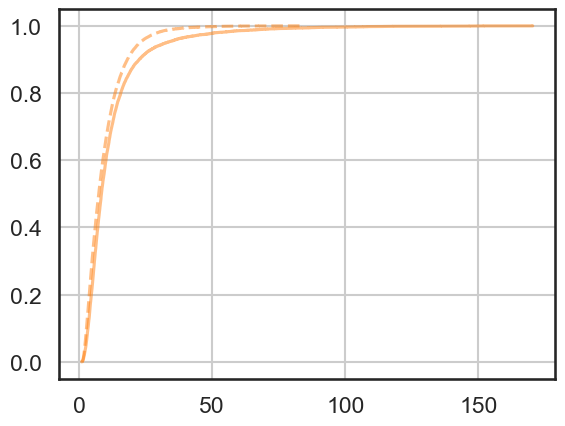

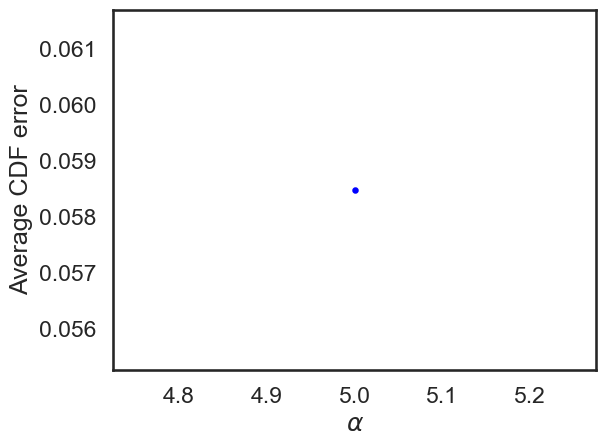

In [80]:
numGrid = 10000
ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
numMyosin = int(np.sum(MyosinInit)*0.6)
actinBiasVal = 0
myosinBiasVal = [5]
ifsave = 0
dwnsample = 1

dist_arr = np.zeros((len(myosinBiasVal)))

for ii in range(len(myosinBiasVal)):
    res = runSimulation(numGrid, numMyosin, randNum, ActinThick, actinBiasVal, myosinBiasVal[ii], ifsave, dwnsample)
    #test = st.ks_2samp(res, allIntYoutB[allIntYoutB<=np.max(res)])

    dist_arr[ii] = cdf_dist(res, allIntWT)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plot_ecdf(allIntWT, 'Experiment', '--', co[1])
plot_ecdf(res, 'Simulation', '-', co[1])

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.scatter(myosinBiasVal, dist_arr, 10, 'blue')
#plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("Average CDF error")
plt.tight_layout()
#plt.savefig("BlebtoWT_alpha scan.png", dpi = 300, transparent = True)

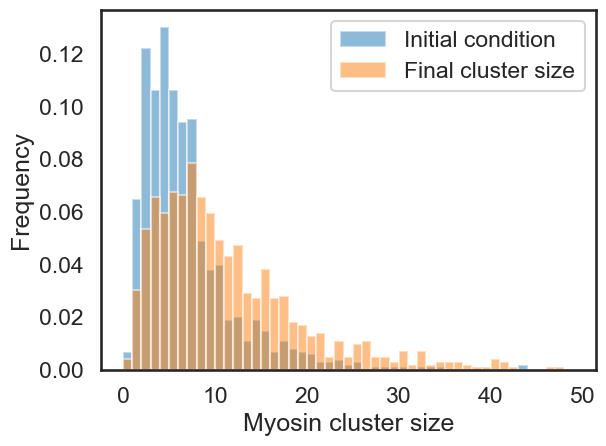

In [23]:
numGrid = 1000
ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
numMyosin = int(np.sum(MyosinInit)*2/3)
actinBiasVal = [0]
myosinBiasVal = 100
ifsave = 0
dwnsample = 1


sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(MyosinInit, bins = np.arange(50), alpha=0.5, density = True, label = 'Initial condition')

for ii in range(len(actinBiasVal)):
    # Run simulations
    ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
    MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
    res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[ii], myosinBiasVal, ifsave, dwnsample)

    plt.hist(res, bins = np.arange(50), alpha = 0.5, density = True, label = 'Final cluster size')

plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_BB_ctrl_numMyosin_26000_acBias_0_myosinBias_0.png", dpi = 300, transparent = True)

4207


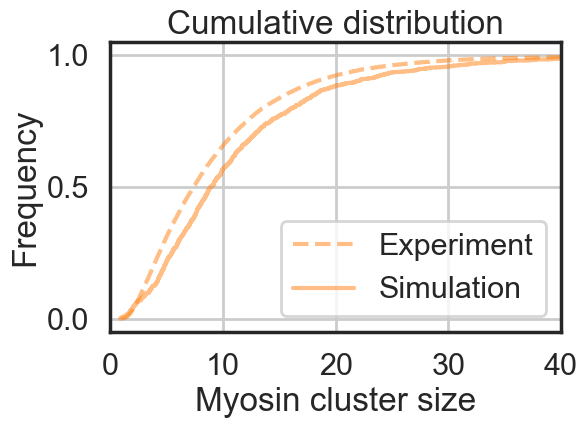

In [38]:
numGrid = 1000
ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
numMyosin = int(np.sum(MyosinInit)*0.6)
actinBiasVal = [1]
myosinBiasVal = 5
ifsave=0
dwnsample=1

print(numMyosin)
# Run simulations

res0 = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[0], myosinBiasVal, ifsave, dwnsample)
#res1 = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[1], myosinBiasVal, ifsave, dwnsample)

sns.set_style("white")
sns.set_context("poster")
plt.figure()
plot_ecdf(allIntWT, 'Experiment', '--', co[1])
plot_ecdf(res0, 'Simulation', '-', co[1])
#plot_ecdf(res1, 'Simulation')
plt.title('Cumulative distribution')
plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()
plt.xlim([0, 40])
plt.tight_layout()
#plt.savefig('myosinBinding_ecdf_BB_ctrl_numGrid10000_numMyosin_26000_acBias_0_myoBias_5.png', dpi = 300, transparent = True)
#plt.close()

0.11742748960617687


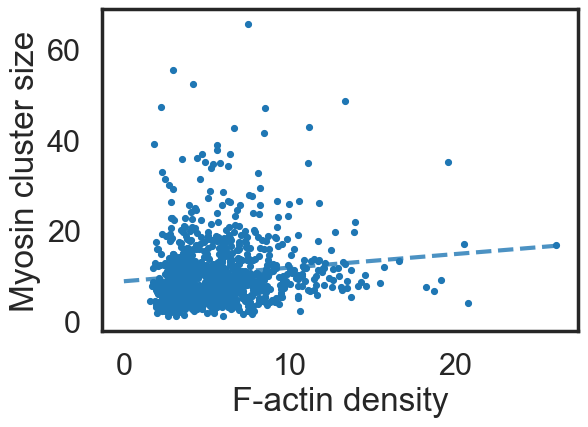

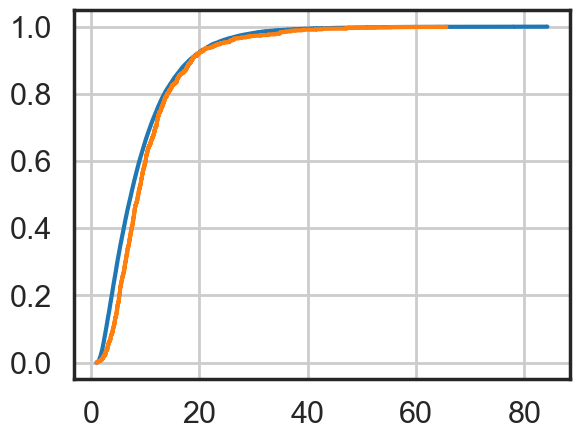

In [47]:
numMyosin = 3000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = [10]
myosinBiasVal = 5
ifsave=0
dwnsample=1

# Run simulations
ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
res0 = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[0], myosinBiasVal, ifsave, dwnsample)
#res1 = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[1], myosinBiasVal, ifsave, dwnsample)
fit = st.linregress(ActinThick, res0)

xt = np.arange(ActinThick.max())
print(fit.rvalue)
sns.set_style("white")
sns.set_context("poster")
plt.figure()
plt.scatter(ActinThick, res0, 10)
plt.plot(xt, fit.intercept+fit.slope*xt, '--', alpha = 0.8)
plt.xlabel("F-actin density")
plt.ylabel("Myosin cluster size")
plt.tight_layout()

plt.figure()
plot_ecdf(allIntWT, 'Experiment')
plot_ecdf(res0, 'Simulation')
#plt.savefig('myosinBinding_ecdf_BB_ctrl_numGrid10000_numMyosin_26000_acBias_0_myoBias_5.png', dpi = 300, transparent = True)
#plt.close()

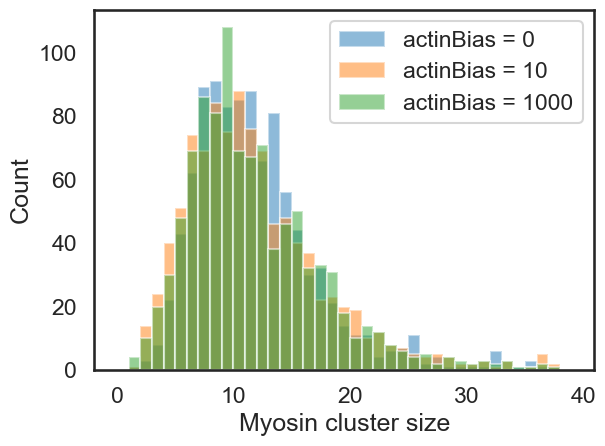

In [ ]:
## Run simulation
# Simulation parameters
numMyosin = 5000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = [0, 10, 1000]
myosinBiasVal = 0
ifsave=0
dwnsample=1


sns.set_style("white")
sns.set_context("talk")
plt.figure()
#plt.rcParams['font.size'] = '16'
for ii in range(len(actinBiasVal)):
    # Run simulations
    ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
    MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
    res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[ii], myosinBiasVal, ifsave, dwnsample)

    plt.hist(res, bins = np.arange(40), alpha = 0.5, label = "actinBias = " + str(actinBiasVal[ii]))

plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_myoBias_0_mu_1_sigma_1_actinBiasComp.png", dpi = 300)

## Dependence on F-actin distribution

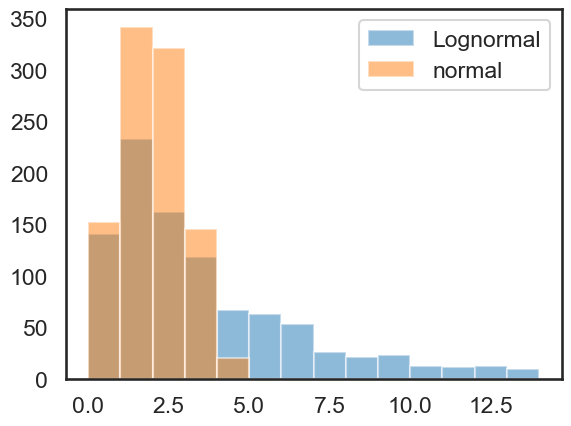

In [ ]:
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(GenActinThick('lognormal', numGrid, 1, 1), bins = np.arange(15), alpha = 0.5, label = 'Lognormal')
plt.hist(GenActinThick('normal', numGrid, 2, 1), bins = np.arange(15), alpha = 0.5, label = 'normal')
#plt.hist(GenActinThick('uniform', numGrid, 0, 10), bins = np.arange(15), alpha = 0.5, label = 'normal')
plt.legend()
#plt.savefig("actin_dist_comp.png", dpi = 300)

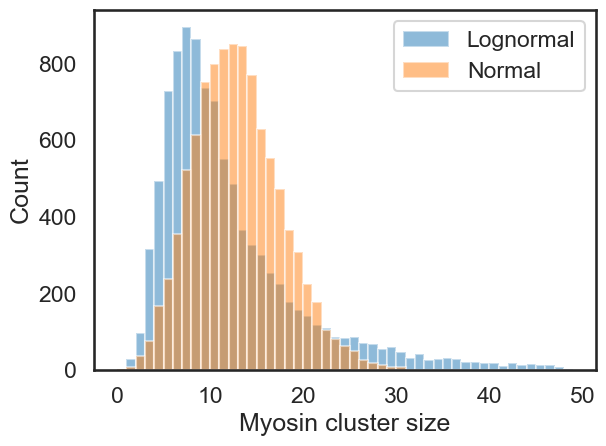

In [ ]:
## Run simulation
# Simulation parameters
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 1
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.

numSim = 10
    
allRes_LN = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_LN[ii, :] = res

allRes_N = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('normal', numGrid, 2, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_N[ii, :] = res

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(np.reshape(allRes_LN, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = 'Lognormal')
plt.hist(np.reshape(allRes_N, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = 'Normal')
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
#plt.savefig("", dpi = 300)

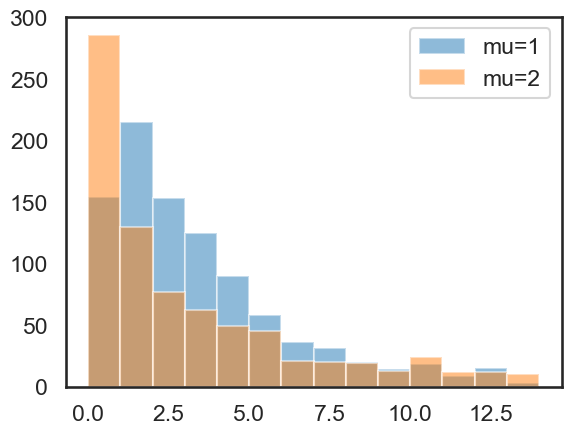

In [ ]:
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(GenActinThick('lognormal', numGrid, 1, 1), bins = np.arange(15), alpha = 0.5, label = 'mu=1')
#plt.hist(GenActinThick('lognormal', numGrid, 1, 0.5), bins = np.arange(15), alpha = 0.5, label = 'mu=0.5')
plt.hist(GenActinThick('lognormal', numGrid, 1, 2), bins = np.arange(15), alpha = 0.5, label = 'mu=2')
plt.legend()
plt.savefig("actin_dist_comp.png", dpi = 300)

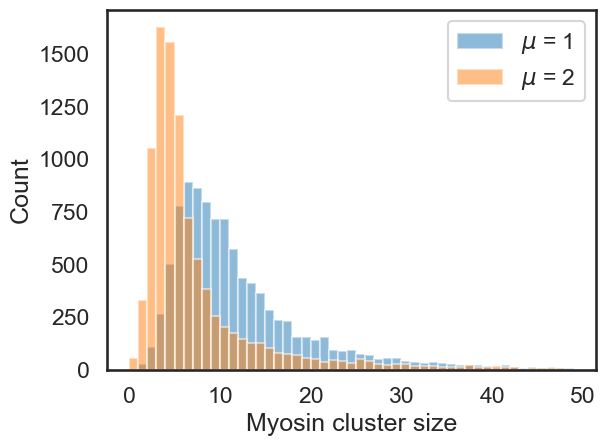

In [ ]:
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 1
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.

numSim = 10
    
allRes_1 = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_1[ii, :] = res

allRes_2 = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 2)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_2[ii, :] = res

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(np.reshape(allRes_1, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = '$\mu$ = 1')
plt.hist(np.reshape(allRes_2, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = '$\mu$ = 2')
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("myosinBinding_histogramComp_myoBias_0_actinBias_1_mu_1_sigmaComp.png", dpi = 300)

## Actomyosin correlation

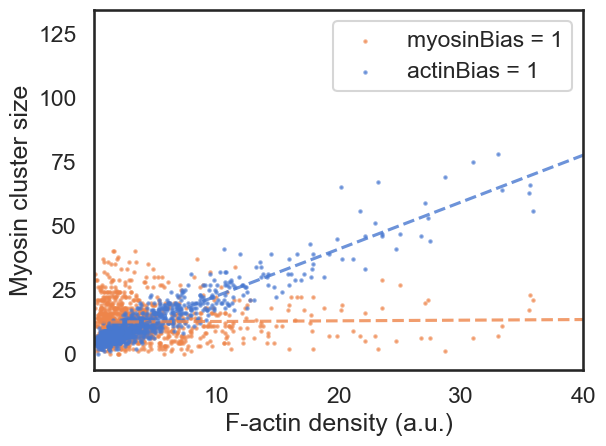

In [ ]:
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
#myoCap = 1000   # Cap the number of myosin per site
merge_thresh = 100000000
Pmerge = 0.
numMyosin = 10000
numGrid = 1000

# Run simulations
resAcBias = runSimulation(numMyosin, numGrid, ActinThick, 1, 0, merge_thresh, Pmerge)
resMyoBias = runSimulation(numMyosin, numGrid, ActinThick, 0, 1, merge_thresh, Pmerge)

acFit = st.linregress(ActinThick, resAcBias)
myoFit = st.linregress(ActinThick, resMyoBias)

sns.set_style("white")
sns.set_context("talk")
co = sns.color_palette('muted')
xt = np.arange(ActinThick.max())
plt.figure()
plt.scatter(ActinThick, resMyoBias, s = 3, color=co[1], alpha = 0.6, label = 'myosinBias = 1')
plt.plot(xt, myoFit.intercept+myoFit.slope*xt, '--', color=co[1], alpha = 0.8)
plt.scatter(ActinThick, resAcBias, s = 3, color=co[0], alpha = 0.6, label = 'actinBias = 1')
plt.plot(xt, acFit.intercept+acFit.slope*xt, '--', color=co[0], alpha = 0.8)
#plt.rcParams['font.size'] = '16'
plt.xlabel("F-actin density (a.u.)")
plt.ylabel("Myosin cluster size")
plt.legend()
plt.xlim((0, 40))
plt.tight_layout()
plt.savefig("myosinBinding_actomyosinCorr_mu_1_sigma_1.png", dpi = 300)

## Coalescence

## Bias towards both F-actin and myosin

### Phase space

In [ ]:
MyosinNum = GenMyoNum('normal', numGrid, 3, 1) 
sum(MyosinNum)

2498

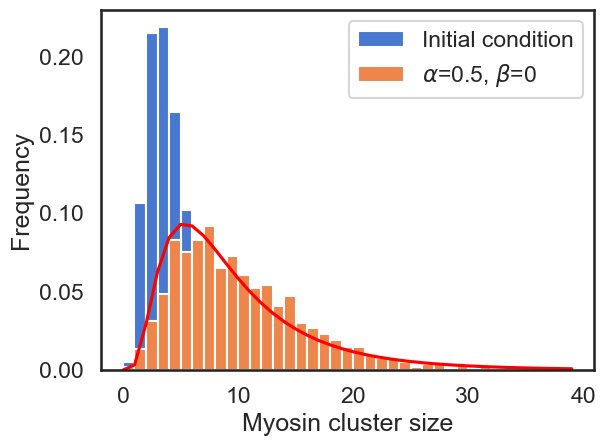

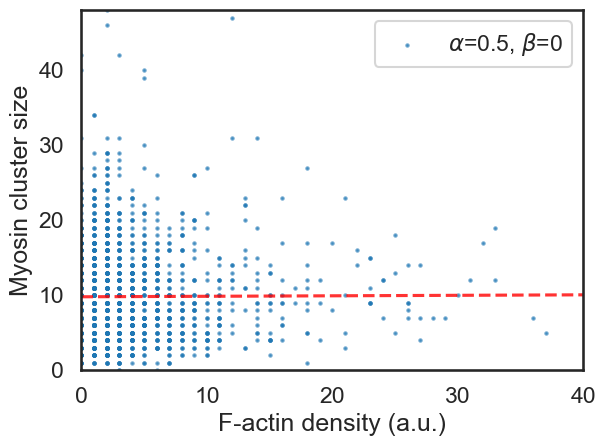

In [ ]:
numMyosin = 12000
numGrid = 2000
actinBiasVal = [0]
myosinBiasVal = [0.5]
ifsave = 0
dwnsample = 1

acBias = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
myoBias = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
mode_array = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
sigma_array = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
# Initialize and run simulation
for ii in range(len(actinBiasVal)):
    for jj in range(len(myosinBiasVal)):
        ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
        MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) #GenMyoNum('normal', numGrid, 3, 0.6) 
        res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[ii], myosinBiasVal[jj], ifsave, dwnsample)

        # Save goodness of fit metrics
    

        # Save mu, sigma
        allData = np.reshape(res, (numGrid))
        (s, loc, scale) = st.lognorm.fit(allData[allData>0], floc = 0)
        idx = ii*len(actinBiasVal)+jj
        acBias[idx] = actinBiasVal[ii]
        myoBias[idx] = myosinBiasVal[jj]
        mode_array[idx] = np.exp(np.log(scale)-s**2)
        sigma_array[idx] = s

        # Save histogram
        sns.set_style("white")
        sns.set_context("talk")
        co = sns.color_palette('muted')
        plt.figure()
        xfit = np.arange(40)
        plt.hist(MyosinInit, bins = np.arange(40), color = co[0], density = True, label = 'Initial condition')
        plt.hist(allData, bins = np.arange(40), color = co[1], density = True, label = r'$\alpha$='+str(myosinBiasVal[jj])+r', $\beta$='+str(actinBiasVal[ii]))
        plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        #plt.savefig('myosinBinding_histogram_myoBias_'+str(myosinBiasVal[jj])+'_acBias_'+str(actinBiasVal[ii])+'.png', dpi = 300)
        #plt.close()
    
        # Save actomyosin correlation
        acFit = st.linregress(ActinThick, res)
        sns.set_style("white")
        sns.set_context("talk")
        xt = np.arange(ActinThick.max())
        plt.figure()
        plt.scatter(ActinThick, res, s = 3, alpha = 0.6, label = r'$\alpha$='+str(myosinBiasVal[jj])+r', $\beta$='+str(actinBiasVal[ii]))
        plt.plot(xt, acFit.intercept+acFit.slope*xt, '--', color='red', alpha = 0.8)
        plt.xlabel("F-actin density (a.u.)")
        plt.ylabel("Myosin cluster size")
        plt.xlim((0, 40))
        plt.ylim((0, min(np.max(res), 100)))
        plt.legend()
        plt.tight_layout()
        #plt.savefig('myosinBinding_actomyosinCorr_myoBias_'+str(myosinBiasVal[jj])+'_acBias_'+str(actinBiasVal[ii])+'.png', dpi = 300)
        #plt.close()

#df = pd.DataFrame({'alpha': myoBias, 'beta': acBias, 'mode': mode_array, 'sigma': sigma_array})
#df.to_csv('params.csv')
#plt.xlabel("Myosin cluster size")
#plt.ylabel("Count")
#plt.legend()
#plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_acBias_0_mu_1_sigma_1_myoBiasComp.png", dpi = 300)

In [ ]:
df

,alpha,beta,mode,sigma
0,0.0,0.0,6.386863,0.332523
1,0.1,0.0,5.907304,0.402334
2,0.3,0.0,5.509874,0.459776
3,0.5,0.0,5.174711,0.503087
4,0.0,0.1,5.985740,0.389910
5,0.1,0.1,5.271528,0.475196
6,0.3,0.1,4.616913,0.551871
7,0.5,0.1,4.244361,0.601536
8,0.0,0.3,5.054862,0.502745
9,0.1,0.3,4.063147,0.581286


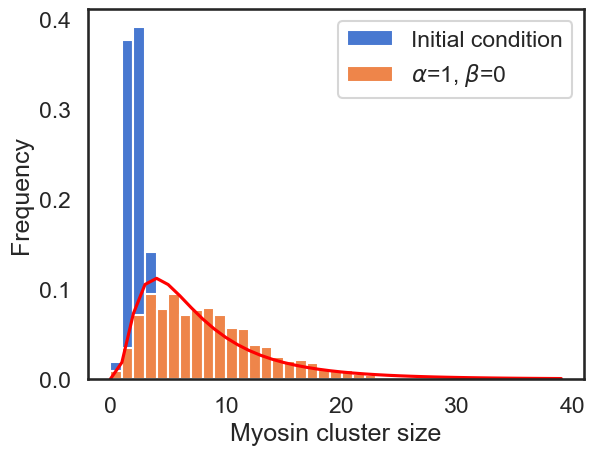

In [ ]:
myosinBiasVal = 1
actinBiasVal = 0
res = runSimulation(2000, 12000, GenMyoNum('lognormal', 2000, 0.8, 0.4) , GenActinThick('lognormal', 2000, 1, 1), actinBiasVal, myosinBiasVal, 0, 1)
#res.tofile('myoNum.csv', sep=' ')
(s, loc, scale) = st.lognorm.fit(res[res>0], floc = 0)
sns.set_style("white")
sns.set_context("talk")
co = sns.color_palette('muted')
plt.figure()
xfit = np.arange(40)
plt.hist(GenMyoNum('lognormal', 2000, 0.8, 0.4), bins = np.arange(40), color = co[0], density = True, label = 'Initial condition')
plt.hist(res, bins = np.arange(40), color = co[1], density = True, label = r'$\alpha$='+str(myosinBiasVal)+r', $\beta$='+str(actinBiasVal))
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()